In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

### Loading Data

In [2]:
TRAIN_DIR = '../Data/Kaggle/DogsVsCats/train/'
TEST_DIR  = '../Data/Kaggle/DogsVsCats/test/'

train_dogs =  [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =  [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [3]:
import cv2

labels = []
images = []
size = 64

for p in train_dogs:
    images.append(cv2.resize(cv2.imread(p, cv2.IMREAD_COLOR), (size, size), interpolation=cv2.INTER_CUBIC))
    labels.append('dog')
    
for p in train_cats:
    images.append(cv2.resize(cv2.imread(p, cv2.IMREAD_COLOR), (size, size), interpolation=cv2.INTER_CUBIC))
    labels.append('cat')

In [4]:
X = np.array(images)
y = np.array(labels)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
print(X_train.shape)
print(y_train.shape)

(20000, 64, 64, 3)
(20000,)


In [7]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=0)

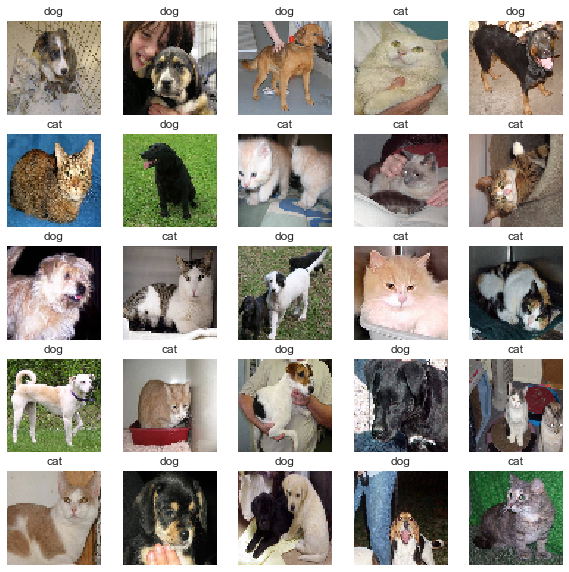

In [8]:
f, axes = plt.subplots(5, 5, figsize=(10, 10))
for index, image in enumerate(X_train[:25]):
    axes[int(index/5)][int(index%5)].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), interpolation='nearest')
    axes[int(index/5)][int(index%5)].set_xticks(np.array([]))
    axes[int(index/5)][int(index%5)].set_yticks(np.array([]))
    axes[int(index/5)][int(index%5)].set_title(y_train[index])

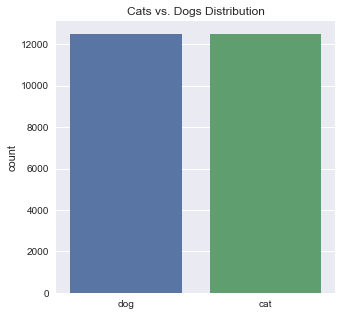

In [9]:
plt.figure(figsize=(5,5))
sns.countplot(labels)
plt.title('Cats vs. Dogs Distribution')

### Pre-Processing

In [10]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype('float32').reshape(X_train.shape[0], -1))
X_valid = scaler.transform(X_valid.astype('float32').reshape(X_valid.shape[0], -1))

In [11]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train) 
y_valid = le.transform(y_valid) 

In [12]:
X_train = X_train.astype('float32').reshape(X_train.shape[0], size, size, 3)
X_valid = X_valid.astype('float32').reshape(X_valid.shape[0], size, size, 3)

In [13]:
print(X_train.shape)
print(y_train.shape)

(20000, 64, 64, 3)
(20000,)


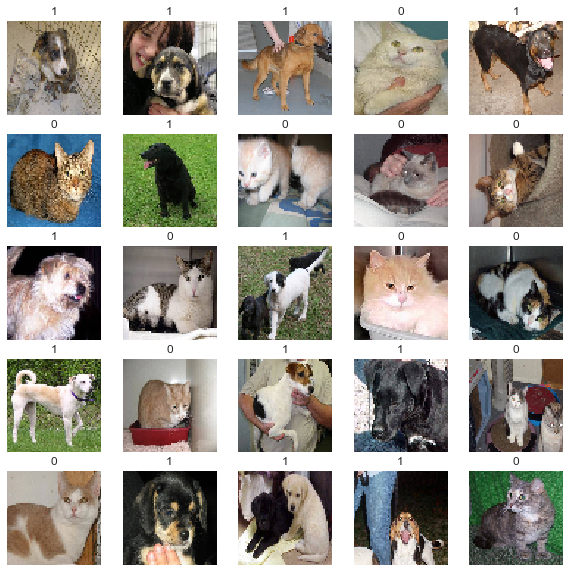

In [14]:
f, axes = plt.subplots(5, 5, figsize=(10, 10))
for index, image in enumerate(X_train[:25]):
    axes[int(index/5)][int(index%5)].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), interpolation='nearest')
    axes[int(index/5)][int(index%5)].set_xticks(np.array([]))
    axes[int(index/5)][int(index%5)].set_yticks(np.array([]))
    axes[int(index/5)][int(index%5)].set_title(y_train[index])

In [15]:
print(np.max(X_train), np.min(X_train))
print(np.max(X_valid), np.min(X_valid))

1.0 0.0
1.0 0.0


### Modeling

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import backend as K

Using TensorFlow backend.


In [17]:
def plot_history(history, x, y):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(x, y))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(x, y))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

In [18]:
input_shape = (size, size, 3)
K.clear_session()

def create_model():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape, activation='relu', name='conv1_1'))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_2'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_1'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_2'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_1'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_2'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_1'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_2'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, name='preds'))
    model.add(Activation('sigmoid'))
    model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy',  metrics=['accuracy'])
    
    return model

In [19]:
def generator(features, labels, batch_size):
    # Create empty arrays to contain batch of features and labels
    batch_features = np.zeros((batch_size, size, size, 3))
    batch_labels = np.zeros((batch_size, 1))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(len(features), 1)
            batch_features[i] = features[index]
            batch_labels[i] = labels[index]
        yield batch_features, batch_labels

Let's use early stop to break the fitting when no improvement is achieved.

In [20]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')   

In [21]:
import time

batch_size = 32

start_time = time.time()

clf = create_model()
hist = clf.fit_generator(generator(X_train, y_train, batch_size=batch_size),
                         steps_per_epoch=X_train.shape[0] // batch_size,
                         epochs=100, verbose=0, validation_data=(X_valid, y_valid),
                         callbacks=[early_stopping])


print("--- %s seconds ---" % (time.time() - start_time))

Epoch 00022: early stopping
--- 1596.321494102478 seconds ---


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


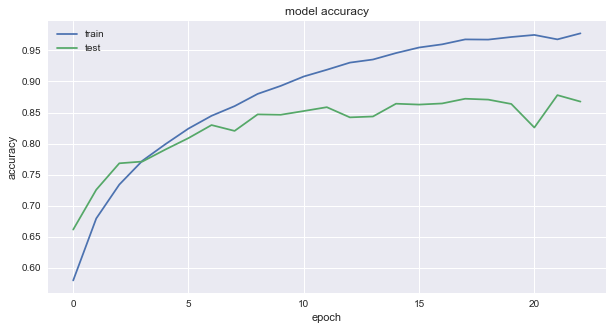

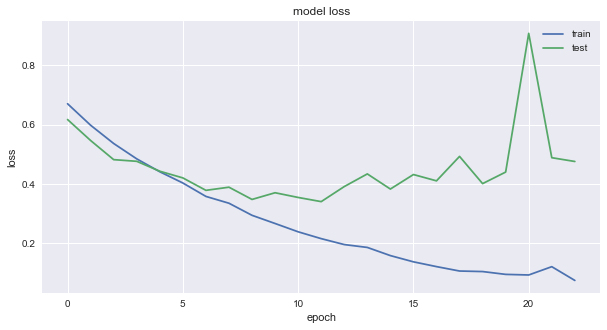

In [28]:
plot_history(hist, 10, 5)

In [23]:
scores = clf.evaluate(X_valid, y_valid, verbose=0)
print("%s: %.2f%%" % (clf.metrics_names[1], scores[1]*100))

acc: 86.76%


### Testing

4992/5000 [============================>.] - ETA: 0s

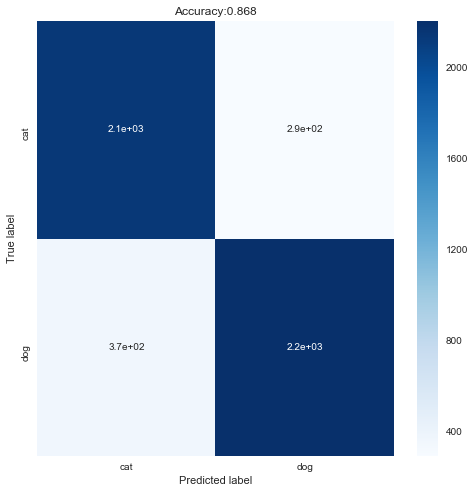

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = clf.predict_classes(X_valid)
cf = confusion_matrix(y_pred, y_valid)

df_cm = pd.DataFrame(cf, index=set(labels), columns=set(labels))

plt.figure(figsize = (8, 8))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_pred, y_valid)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Layers Visualization

In [25]:
from vis.visualization import visualize_activation
from vis.utils import utils
from vis.input_modifiers import Jitter

from keras import activations

In [26]:
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 64, 64, 32)        896       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 16, 16, 128)       73856     
__________

#### Dense layer Activation

In [31]:
layer_idx = utils.find_layer_idx(clf, 'preds')

clf.layers[layer_idx].activation = activations.linear
clf = utils.apply_modifications(clf)

filter_idx = 0

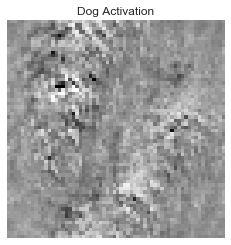

In [45]:
plt.figure()

# We will seed with optimized image this time.
img = visualize_activation(clf, layer_idx, filter_indices=0, input_range=(0., 1.), input_modifiers=[Jitter(16)])
plt.imshow(img[..., 0])
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.title('Dog Activation')

In [47]:
from vis.visualization import get_num_filters

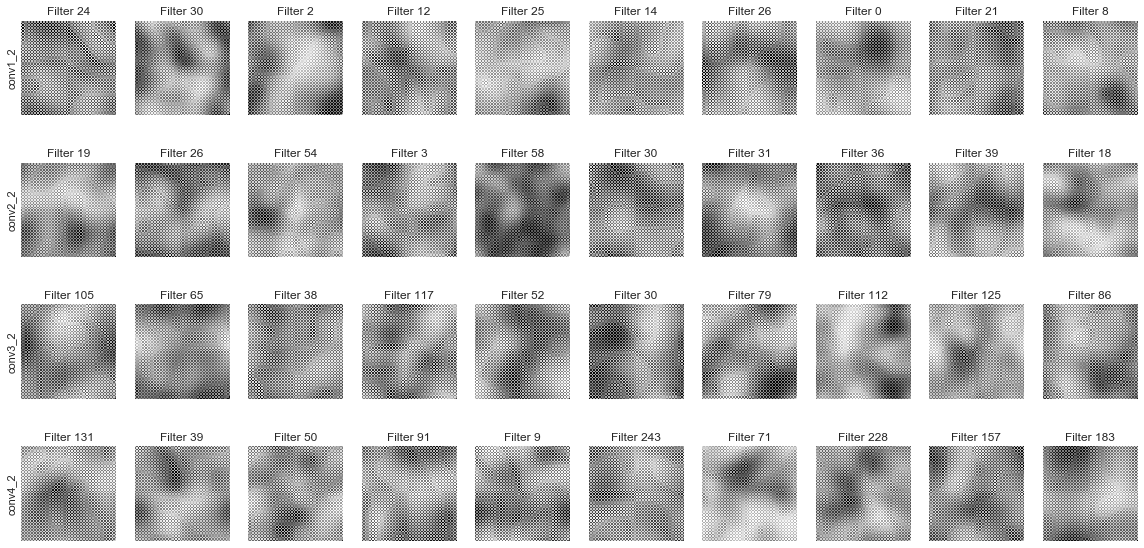

In [51]:
n_filters = 10
conv_layers = ['conv1_2', 'conv2_2', 'conv3_2', 'conv4_2']
f, axes = plt.subplots(len(conv_layers), n_filters, figsize=(20, 10))

for i, layer_name in enumerate(conv_layers):
    layer_idx = utils.find_layer_idx(clf, layer_name)
    # Visualize random filters in this layer.
    filters = np.random.permutation(get_num_filters(clf.layers[layer_idx]))[:n_filters]
    # Generate input image for each filter.
    for j, idx in enumerate(filters):
        img = visualize_activation(clf, layer_idx, filter_indices=idx, input_modifiers=[Jitter(0.05)])
        axes[i][j].imshow(img[..., 0])
        axes[i][j].set_xticks(np.array([]))
        axes[i][j].set_yticks(np.array([]))
        axes[i][j].set_title('Filter {}'.format(idx))

for i, row in enumerate(axes):
    for j, cell in enumerate(row):
        if j == 0:
            cell.set_ylabel(conv_layers[i])

### Submission

In [ ]:
images = []

for p in test_images:
    images.append(cv2.resize(cv2.imread(p, cv2.IMREAD_COLOR), (size, size), interpolation=cv2.INTER_CUBIC))

In [ ]:
X_test  = scaler.transform(X_test.astype('float32').reshape(X_test.shape[0], -1))
X_test  = X_test.astype('float32').reshape(X_test.shape[0], size, size, 3)